# Datatsets  

To be used for training, validation, and test data. They need to be the cleanest of the clean.  

I have a table of them that I will upload also, I just don't love the tables in markdown (and it's a fairly lopsided, ugly table anyway). To be uploaded when I find all the papers I need to reference.  


## Phyla  

#### Porifera

Sponges, as usual, are difficult to come by. Even more so since Compagen doesn't exist anymore.  

I looked for Sycon, because I know it's supposed to be one of the better ones, but since they took the Compagen site down, it is harder to find. I think I did at this link: https://datadryad.org/stash/dataset/doi:10.5061/dryad.tn0f3. But if I can't find the reads (and it doesn't look like they were ever posted anywhere) it won't be much good. So there's that.  

Right now I have these:  
1. Amphimedon queenslandica  
2. Ephydatia meulleri  


#### Ctenophora  

Ctenos are also pretty scarce. I contacted Joe to get some reads for Mnemiopsis, and he has some others as well, so I'll get what I can from there. 

Current ctenos:  
1. Mnemiopsis leidyi  
2. Pleurobrachia bachei
3. Beroe  

#### Cnidaria  

Definitely more cnidos to be had, so that's good. I discovered that the best way to search for datasets appears to be looking up genome assemblies on NCBI (if you go to the legacy genome assembly page, there is a place over on the right that says "FTP directory for GenBank assembly" (or it might say RefSeq sometimes) and if you click on that, it will take you to a page that looks like it was made in 1997 that is really just a directory full of resources. Find the one that ends in "genomic.fnz.gz" and right click to save the link. That's the only way I know to get the URL you need to curl.) and then looking up the raw read sets on ENA.  

I prioritized chromosome-level assemblies, but also took some scaffold ones. Also didn't pay too much attention to taxonomy, so closely related things were okay, and not having some groups represented was okay. I'm trying to get a good volume of reads, and I don't think it matters a whole lot that some of them come from the same genus.  

Current cnidos:  
1. Acropora hyacinthus  
2. Acropora millepora  
3. Cassiopea andromeda  
4. Aurelia aurita  
5. Diadumene lineata  

#### Mollusca  

For these guys, there seemed to be more species available, but fewer reads for each species. Hopefully it won't make a huge difference.  

Current mollusks:  
1. Achatina immaculata  
2. Archivesica marissinica  
3. Arion vulgaris  
4. Conus ventricosus  
5. Crassostrea gigas  
6. Dreissena polymorpha  
7. Gigantopelta aegis  
8. Lanistes nyassanus  
9. Margaritifera margaritifera  
10. Mercenaria mercenaria  
11. Pomacea canaliculata  
12. Ruditapes philippinarum  

## Processing  

These are the reads I'm going to start with for now. One of the best methods I know to get decontaminated reads is to map them onto a good assembly, so that's the goal for these sets. But before I do that, there are lots and lots of processing steps to take care of, so let's get to it.  

Most of this (minus naming basically) is happening from outside the directory that houses the actual data, here: `/scratch/genomics/spillanej/contamination`.  As I get more and more files, I will have to move things around so that I don't end up hitting my quota and cancelling all my jobs. Rebecca lined up some more space (5TB, unscrubbed) for me, here: `/store/public/spillanej`. I want to think about how I'll use it, but I'm okay for now.  

### Getting the reads and assemblies to a usable place  

### Genomes  

Genomes don't take up nearly the space that reads to, but I still want to be mindful of how many copies of them I have.  

Process:  
1. Download all genome files  
2. Rename to match Genus_species.fasta  
3. Format fastas to get rid of non-nucleotides  
4. Make the header names simple and informative(?)  
5. Index each genome for mapping  

#### Renaming

The assemblies all have names that are super similar. This is annoying. I have been renaming them as they download so that I don't get confused and end up with a bunch of incorrectly named genome assemblies. That would be a disaster. I have also been renaming the read files, either as soon as they download, or when I've downloaded all the ones I'm using from a particular platform and am catting them (or zcatting them) together.  

#### Formatting fastas  

Remember how the Actinia genome had some weird non-nucleotides in it? Well I do. And anvi'o had a script that solved that problem. Presumably other programs do too, but I already installed anvi'o and know how to use that script, so you can guess which program I decided to use for this. Am I sure that they all need this? No, definitely not. Some might be totally fine. But in the interest of treating them all the same way, I'm going to run it for all of them. It certainly won't hurt them if they are already good to go.  

`anvi-script-reformat-fasta datasets/Actinia_tenebrosa.fasta -o formatted_genomes/Actinia_tenebrosa.formatted.fasta --seq-type NT`  

This script also technically can change the headers so that they are simplified, but it doesn't seem to allow for much customization, so they don't end up very informative. As in, they would all be labeled the exact same way, so if I ever needed to identify what species we were talking about, it might be difficult. Would this kind of simplifying be fine for my purposes? Maybe, but since I'm not sure, I'm not going to risk it. See below for what I actually did.  

#### Simplifying the headers  

I don't know if I need to care about the read headers, but I'm hoping not. The assembly headers might not be super important after the mapping stage, but I still feel the need to fix them before I do that step, just in case. I guess working with Anvi'o has made me paranoid. So I used my tried-and-true but fairly janky way of making the headers in the genome assemblies simple and informative. From inside the directory that houses these (formatted_genomes), this is what this looks like:  

`awk '/^>/{print ">Genus_species_" ++i; next}{print}' Genus_species.formatted.fasta > ../simple_headers/Genus_species.fa`  

### Reads  

I want to treat all the read files the same too (according to platform) so even though they might not all need all the steps, I'm still going to do them for all files.  

1. Download read files  
2. Unzip read files  
3. Cat read files together according to platform  
4. Trim all reads (aggressive adapter trimming and nonexistent quality trimming)  
5. Map them to their respective genomes  
6. Save all those that map in new fastq files  

I'm going to have to see how large the mapped read files are, but my thought is that I'll be able to keep them in my /scratch/genomics space, and can transfer the trimmed read files (before mapping) and the bam files to my /store/public space. Zipped, of course. The original read files I'll delete, as I can just download them again if I ever need them again.  

#### Downloading   

I'm just using curl commands to get them all downloaded. Before, I was doing this on the login node, which is fine, but moving forward I'm going to pop these commands into scripts that I can submit as jobs.  

#### Samtools steps  

I was trying to figure out what samtools processing steps I need to go through, since these files take up a lot of space and I don't want to make ones that I don't really need. But I definitely need a bam file of all the reads that mapped to the genome, and I need the sorted version for blobtools to work.  

Rebecca mentioned that she has not had good luck with the filtering of these files. That sometimes the file sizes between the files at different stages of filtering are the same size. So I am doing a trial run on one of them (Acropora hyacinthus). I'm having it spit out another stage of sam file, one from after it should have filtered out all of the things that don't map. Hopefully they are different, and I can look at it enough to feel confident about the samtools filtering step.

### Snakemake  

I'm also working on learning Snakemake (here's some docs: https://snakemake.readthedocs.io/en/stable/index.html), so I'm hoping to do most of these things from in Snakemakes platform/format/style/syntax. I did one batch of genomes first, and got them as far as the genome indexing step, which was the first step I figured out how to do in Snakemake. I will definitely upload my Snakefile to github, but I'll also probably drop pieces of it in here as I make rules.  

### Space!  

I knew this was coming, but I have officially run out of space in my scratch/genomics directory! Good thing Rebecca made that other one for me. I'm going to transfer all of the raw reads there, at least until I get them trimmed. Then I will probably delete all the raw ones, and just keep the trimmed ones. I have all of the accessions recorded, so if I really need to get some or all of them back at some point, I can.  

I'm going to have to be a little strategic about this. The compute nodes of Hydra can't really interact with files in the /store/public/spillanej/ space, so I need to use it for storage and not as a place to keep things I'm interacting with more often. That, combined with the fact that these files take a while to move around means I'd rather keep them somewhere slightly more accessible, so I'm going to strategize what the best thing to do with my storage space is. I want it to be useful, and to keep things that I don't need right this minute, and that will free up some space to work in my scratch directories.  

ALSO, I found out that the way I catted (or rather, zcatted) the reads together is freaking out the process, so I'm going to have to redownload the ones I did that to. Everything in the first batch (Ephydatia muelleri, Pleurobrachia bachei, Nematostella vectensis, Cassiopea andromeda, Acropora hyacinthus, Acropora millepora, Actinia tenebrosa, Amphimedon queenslandica, Aurelia aurita) should be fine, since I unzipped those before catting them together, but all the ones I did second (Diadumene lineata (illumina reads only), Arion vulgaris, Crassostrea gigas, Dreissena polymorpha (pacbio reads only), Lanistes nyassanus, Margaritifera margaritifera, Mercenaria mercenaria, Pomacea canaliculata (illumina reads only), Ruditapes philippinarum) will need to be redownloaded. I actually don't have to do this for all of them, because if the read files were singular, I never catted them, and they are still fine (Diadumene lineata (pacbio reads only), Achatina immaculata, Archivesica marissinica, Conus ventricosus, Dreissena polymorpha (illumina reads only), Gigantopelta aegis, Pomacea canaliculata (pacbio reads only)). This is a bummer, because that took a while, but it will be an opportunity to automate more of the process, and it will help free up space in the short term. 

**Oof, this space thing is really coming for me**  
I keep having jobs that don't finish correctly because I'm hitting my quota. I didn't realize, but the /pool/genomics/spillanej/ space is different from my current space, so I'm going to start writing a ton of files there. And that's where I'll transfer all the sorted bam files and all of the reads that have been mapped to the genomes. This should give me much more breathing room than before.  

**Ok, but not really**  
It turns out there are only 2Tb of space in the /pool/genomics spot, so not as much writing there! But I did get my quota temporarily expanded in the /scratch/genomics spot, so no more worries about space for a bit.

As I finish doing the mapping for each dataset, I've been managing the space all the things are taking up. Since I can't access the /store/public/spillanej/ space from compute nodes, I've been storing things (logical use, I know) that I won't need now but might be useful to have later. I've put all of the results from the decontamination tests I ran earlier there, along with all the sam files for all the marine invert datasets and the trimmed reads (the ones before mapping). I didn't save raw reads because I can always download those again later from the repositories if I need them, but I chose the trimmed ones because they have already been processed a bit. And the sam files can be converted into any kind of related file that I need, so I saved those too.  

I ended up running out of space in the store space, so I stashed things I did not have room for in the /pool/genomics/spillanej/ space in the corresponding directories. I think this is just true for the Amphimedon trimmed reads right now.  

I am also going to move all of the sorted bam files over to the pool/genomics space. I'm pretty sure there is room, and I can access that from compute nodes, so when I want to do something with them, they will just all live in one spot.

Okay, so as things stand on 7-8-22, all of the sorted bams are in the pool/genomics space, all of the mapped reads are in the scratch/genomics space. All of the trimmed reads are in the store/public space, along with all of the decontamination test results that would fit. I'll keep the test results there for now, but I don't think I'm committed to them long term.  

### Further Decontamination  

The decontamination process is not over just because I've mapped all the reads to their genomes! There could still be lurking contaminants. I think I'm going to do this decon step in two different ways: one where I very carefully try to pick out each little tiny contaminant read, and one where I take a quick glance and anything that looks even a little funny will get tossed.  

I'm going to start with Kraken because honestly I feel like I understand how to use it better. (When I look at Blobplots, I find them interesting, but ultimately I am unsure what to do with them. So.) The thing with Kraken results is that it will often categorize a sequence as "human" (or something else) with almost no evidence. The sequence will be 2700 bases long, and it will find two kmers that look human, so it classifies the whole thing as a human sequence, ever though all the other ones were unclassified. So I need to stop it from doing this (because we kind of *want* things to be unclassified, at least if that means it's not a human or bacterium or something. But I obviously don't want it to be totally insensitive either, because that's the whole point. I'll need to write a parsing script for the output of kraken (this is the log file; there are tons of outputs) that can eventually filter these results. First though, I'll just have it spit out some stats so that I can figure out what kind of threshold might make sense. First first though, I need to run it. Hoping to do it with Snakemake, but we'll see.  

Snakemake has something weird happening to it on Hydra. There is some kind of file latency problem, so that it only does some of the jobs it sets out to do. When I run it with kraken2, it makes some of the output files, but not others (or it makes them momentarily and then deletes them because it says they could be corrupted), so I'm going to put it away for now. I think I did figure out how to do it though, so that's at least something.  

Back to working on my parser for kraken2 output. It turns out that you can redirect the output that normally just goes to stdout (which on Hydra gets picked up by the logfile) to its own file just like you normally would, and this makes for a much cleaner output file without a bunch of uneccessary lines at the top and bottom.  

I think what I want the output from this parser to look like first, is a csv where each line corresponds to a line from the output where the reads were classified. Since I'm not expecting kraken2 to be able to classify these organisms correctly, I think it's safe to accept the unclassified reads. But it has this bad habit of saying something is classified when the number of kmers it finds to put the read in that category seems really flimsy to me. Sometimes only a couple of kmers out of the whole read. I've tried to read and find out how it is making these decisions, but it's still not clear to me. So what I want to calculate is the ratio between classified and unclassified kmers.  

Since I think there will always be at least one unclassified kmer in the classified lines (just a hunch, could be wrong), I'm going to do classified/unclassified so that there is less chance of dividing by zero and freaking everything out. This way, if the ratio number is below 1, it means there were more kmers that were unclassified than classified, and the farter away from 1 we get, the more unclassified kmers compared to classified ones there were. Then anything above 1 will indicate that there were more classified than unclassified kmers, and the farther you get above 1 the more classifieds there were compared to unclassifieds. Then I can look at distributions of these and hopefully get a better idea of how often this happens.  

Update 8-24-22: I was super wrong about that hunch, haha! Turns out that there are plenty of times that there are no unclassified kmers, and I can't divide by 0, so that's not going to work. After thinking about all the ways that I could make these ratios work, I decided the much easier thing to do would be to calculate percentages instead of ratios.  

ALSO, be careful of copying and pasting lines of a file to use as a test file. Much safer to use `head` and then download the test file. When I copied and pasted from a `less` command, it changed all of the tabs to spaces, which was then a total disaster for parsing the file. I thought it was going to be a whole thing before I realized what was really going on.  

I've realized now that this parser thing (it will eventually be a parser, but right now it is a stat finder) needs to calculate stuff for all of the lines, not just the ones that are classified. Sometimes, it is pretty much doing exactly the same thing for the classified and unclassified ones, so that makes me wonder even more why some are designated the way they are. I think we need some density plots in our lives.  

Ok, still a stat finder, but I'm really liking where we are with it. I've made it with a switch that flips back and forth between paired reads and unpaired reads, so I can use it for illumina or pacbio reads. In both cases, it is spitting out the percentage of classified kmers out of the total number of kmers in the read, along with the classification status, and the read id. So once I figure out what I want to do, and where I want my threshold to be, it should be relatively straightforward to have it pull the reads I want too. 

Update 8-29-22: Ok, the bulk of this script is working great, and has been since right before the weekend. But now that I am trying to run it on big files, I'm finding all the little instances that are not typical. Of course. So first I discovered that the index number in the sets of numbers that tell you how all the kmers were assigned does not have to be a number. It can also be an "A" if the kmers contain ambiguous nucleotides. Ok fine, this is an easy enough fix. Just add in an elif statement telling it to skip that particular pair if there's an "A". Onward.  

Next thing that I noticed: the output files are not nearly as long as they should be. I mean, they should be hilariously long. The ones for the illumina output should have twice as many lines as the output files from kraken, and that is already the same number of lines as there are reads. Some of these should be wildly large. But they weren't. The line numbers didn't match up at all, and it was choking on a line not that far down. So I looked at the logfile, and it turns out they were erroring because of a division by 0! That shouldn't happen! These are percentages! How is the total, which is the denominator, 0? Well, reader, I wracked my brain and decided that this could happen if **all** of the kmers had an ambiguous nucleotide. That's not that outlandish, it would only take a couple in short illumina reads, and then you could easily have 0 on the wrong side of that division problem.  
 
But reader, this is where the plot thickens, because no sooner had I deduced this, than I remembered that grep exists (I'm tired, give me a break) and I could just check. So I grepped the last recorded read name from the parser output csv, and had it also give me the next line, and what did I find? Sweet confirmation of my absolute correctness? Nope. Instead, another problem. I guess there are some reads that are too short to have any kmer assignments at all. And then they look like this: `U	SRR10033059.353806141	unclassified (taxid 0)	32|150	|:| 0:116`. What a bunch of nonsense. But of course, nonsense that would also lead to this particular unfortunate scenario. *sigh*  

So now I'm trying to figure out what to do to solve both of these issues so that I don't have to worry about them later. I'm sure, given the size of the files, that they both exist somewhere even if they haven't popped up yet. *seconds later* This is hilarious. The thing with the abbiduous nucleotides and nothing else is the exact situation of the other one in my two-species test. Perfect. At least I got confirmation. Looks like this: `U	DRR089920.530215	unclassified (taxid 0)	287|295	0:253 |:| A:261`.  

Ok, using this knowledge, I've now manufactured the best test file of all time. Only 10 lines long, uses illumina output, contains both of the division by 0 scenarious above, as well as a normal ambiguous nucleotide line. Should work well for testing. Now if I can just figure out how to make this thing work.  

Update 8-30-22: Alright folks, it's time. My test file is on point, I've saved a copy of the script in another location, and pushed it as-is to github. Time to wreck this thing.  

What do I actually want to happen in the above scenarios? I'm initializing the lists with a "0.0" float already in place, so they are never just completely empty. But I think I just have to build in a check to make sure the total won't be 0 for the division. But what do I want it to be in that situation? If the total is 0, it means the total classified is also 0, so I could just make the percentage 0 in that case. But if there is something *that* shoddy about the read, maybe I don't want it included at all?  

I don't think I do. I might just discard the read and/or read pair if it's like that. If the read is too short to be properly analyzed, I'm sort of surprised it made it this far, and if it has a bunch of ambiguous nucleotides (I would need at least a couple sprinkled at regular intervals, and likely would have a lot more), it's probably not going to be very good food for my eventual model. Ok, they are getting excluded. Now though, I can't be alarmed when the numbers of lines don't match up between the kraken output files and the parser output files. They will be at least a bit different, and possibly very different.  

So now I'm trying to figure out how I should make the script differentiate between the ones it should go ahead and calculate, and the ones it should just skip over. Since I'm having that particular function return the percentage, I feel like I can't leave it totally empty (and I'm getting an error about it not being assigned early enough) so it looks like it will need some kind of obvious placeholder that I can rule out later during the part where I append all the good lines to the list that will become the output file.  

Update 8-31-22: I think I have finally solved the problems I set out to solve. Realized my last mistake was an indentation error. Classic. So now I just need to get it to run on Hydra. I'm just going to start with the first two (alphabetically) to see how long they take and how much memory they use. The test ones from before errored after having used barely any memory, so I'm not giving it a lot to start out with.  

Um. So. It didn't error immediately (woo!), but eventually (25 minutes or so?) it was killed because of a memory thing. I upped it based on the memory it said it used (which was kind of a bit, 30G-ish) and gave it another try. Killed again after 14 minutes because of memory. Looked at the log file this time and the problem is showing up as a traceback. So even though I'm never reading in the whole input file, it's trying to store too much. I guess the output list before it gets written to a file is getting too long for it to hold in memory. I could try to make it write as it goes without freaking it out too much, but honestly, it's probably time to subsample. I'm just trying to get stats, as long as I subsample randomly, there is no reason I need the whole entire thing.  

I do kind of wonder what it can handle. The first file I tried was 33G, so not that. I'm just going to do the three smallest, and then I'll subsample down to meet one of those levels. You know what though? Ok, I'm going to let this run because a. I've already set it to go and 2. I am legit curious about when it will fail out, but I just checked how many lines are in the smallest file (Conus_ventricosus) and it's already almost 5 million lines long. That seems like plenty.   

That finished so fast! Subsampling was definitely the answer. I'm just testing on the Illumina data right now because they will have longer output files. On this one, the original file had 4,948,191 lines, so the output of the parser should have twice that, or close to it. Lo and behold: 9,834,306! It doesn't need to be exact, since I had to build in allowances for weird situations, plus that's a respectable number anyway. Also, it used less than 2G of memory and about 30 seconds. Sold. The other two (I ran them in a loop together) went fine also, finished in 6.5 minutes, but used a lot more memory. More like 14.5G. But it seems like if I keep these small this whole thing could be really quick.

**Update 9-1-22:** I plotted the percentages of classified kmers on a density plot this morning. It was a little interesting. I first tried to do it right in here with plotnine. My ggplot R code doesn't transfer exactly, but the essentials worked fine. The problem was that once I got all that stuff worked out, the files were too big. Even when I tried to take just the top half, it made my kernel quit repeatedly, which is pretty annoying. So I abandoned ship and just did it in R Studio like I have before.   

The density plots themselves are... interesting. So far I've just done the one from Conus illumina data and Acropora millepora illumina data, and they are reasonably similar. Ish. They both have intensely high points at the 0 mark that are so extreme that you really can't see the rest of the patterns. So in both cases I limited the y axis to around 20 so that you can actually see stuff. I'll put both the original and the modified one for Conus below.  

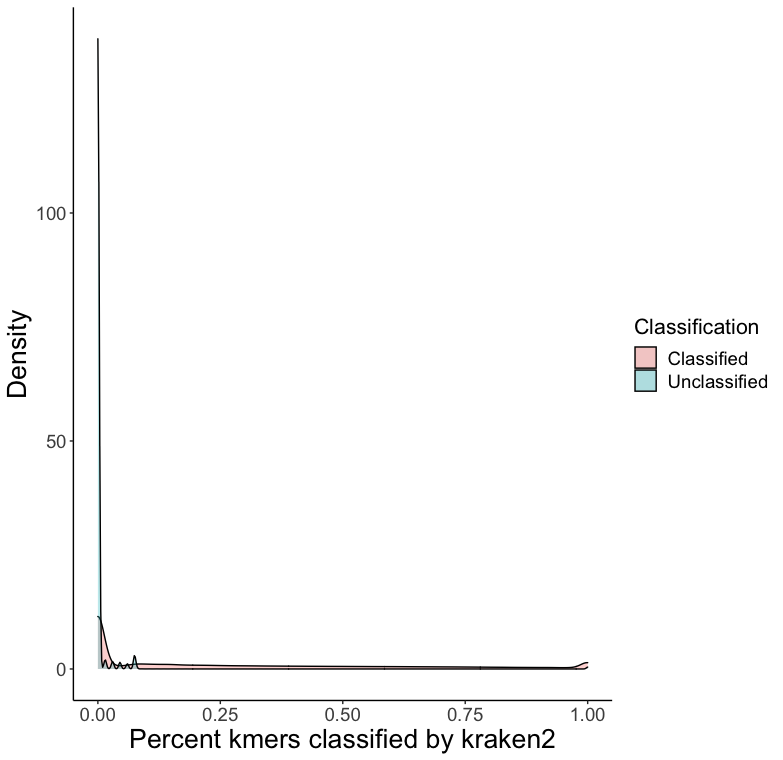

Ok, and here's the modified one, which is really just zooming in on the lower part.  

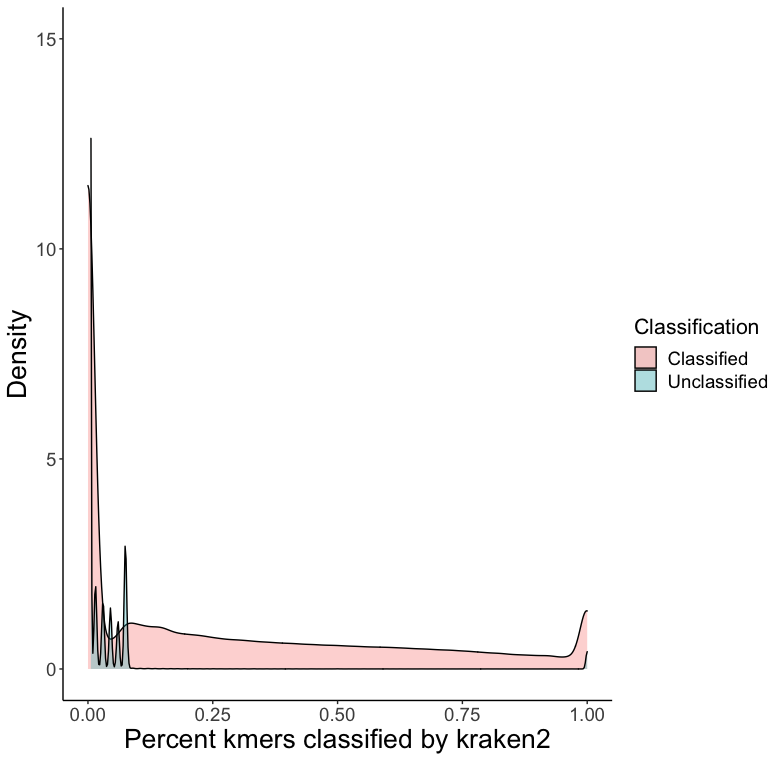

I understand the giant peak at 0 for the unclassified kmers, but why would they also have a little peak at 1? Also, the long slope of the classified ones does not exactly inspire a lot of confidence. I was sort of hoping there would be a lull somewhere in the middle that I could make into a logical cutoff, but I might just have to make one up.  

Also, these plots don't show it, but I know for a fact that there are read pairs in these data sets that have one read completely unclassified, and the other completely classified as human. I don't know what that is about, or how often it happens (should be never, honestly), but I'm fine just throwing those out. All of these decisions will have to get written into the parser at some point, but I'll have to make some decisions first, so for now, I'm going to get some more of these plots. I want to test some pacbio ones and also see how consistent the illumina ones are.  

# Bacterial Datasets

I haven't been as focused on these, though maybe I should have been. This was a difficult process. I started by trying to avoid NCBI, because when has it ever been the one that worked the best? So I looked into Ensembl, which has loads and loads of options to download all kinds of things that are not genomes. And when I tried to download genomes, something about the accession I was trying to use didn't work.  

So then I tried the ENA, thinking that if that was where they were deposited first, maybe that would be easier. Alas, no. I got as far as downloading a program that wouldn't work without another piece of software that I wasn't allowed to download without an account. So I did all that, and it still wasn't working the way I needed it to. At this point, days had gone by. DAYS. So I dropped into the Hydra/Bioinformatics help session that day, and explained that this was just not working. Rebecca was great and in less than 20 minutes had a more promising solution (using NCBI, no less!) than I had been able to find.  

The key is this document: https://ftp.ncbi.nlm.nih.gov/genomes/genbank/bacteria/assembly_summary.txt, which has all of the bacterial genomes available on NCBI, and a good amount of info about them, including their locations (sort of). You can tell what info it has in more detail with this document: https://ftp.ncbi.nlm.nih.gov/genomes/README_assembly_summary.txt. It also helpfully has the fields numbered.  

I already had half of a script written to get a random sample of genomes (from when I was working with an Ensembl spreadsheet earlier in the week), so I just tweaked the first part to work with this new spreadsheet, and did a random sample of all the genomes. I tried downloading a couple manually, and the location on the spreadsheet downloads a file that has all the names of all the different types of data you can download, so I put together all the relevant bits of information and reconstructed the location of the full genome fasta file. All of this is here: /Users/jenniferlspillane/Desktop/Analyses/contamination/subsample_list.py, along with the spreadsheet of all the genomes.  

### Testing  

So, I did a little test to see if the script was working well (I mean, I did TINY tests first, but this was the first real one) I made it so that you can just select the number of genomes you want it to randomly sample, so it's really easy to change. I picked 117 to start (because there are 11,778,938 genomes in this file, and that seemed like eliminating enough decimal places off the end? IDK.) and generated a text file that I transferred onto Hydra. Then it was really easy to make a job that just had a wget command in it (no need for tons of memory or time) with the "-i" flag (to tell it to look in the file) and the file of the genome locations. It finished wicked fast (maybe two minutes? Maybe less) and downloaded 111 genome files.  

I know what you're thinking. "111? Didn't you tell me two seconds ago that you pulled out 117?" Yes, dear reader, I did. I'm not 100% sure what happened with those last six. The wget command (sort of annoyingly) spits out *lots* of stuff into the log file, so I just ended up grepping for the ones that went wrong like this `grep "ERROR 404" -B 3 test_genomes.log > did_not_work.txt` and saving them in that file. It's weird that the address at which it tried to find the genomes doesn't look complete in five of those examples, and it makes me wonder what went wrong, and why the script isn't putting "genomic.fna.gz" after the assembly name like it's supposed to. In one of the cases, the genome is names something super weird, with a lot of legit English words in it, so it's not really that surprising to me that that location ended up not working out. I'm not really sure if this is a problem or not yet. I'm going to have to download more and see how widespread it is. But also, I'm not sure I care? I don't really mind which genomes I have, as long as I have enough of them. That said, I would prefer that they were being left out somewhat randomly, and not systematically, since that might skew something.  

**Small Update:** The one that was really weird looking had spaces in the genome name, so obviously that wasn't going to work.  